## Purpose of the Analysis
Since I couldn't track all the deliveries and tips made during a specific hour, I tried to discern it from the schedule using this approach: I grouped all the days I was working during a specific hour: *I summed up all the deliveries and tips done in those entire days and I calculated the delivery/hour and tips/delivery ratios.*

It is a **very conservative** approach since the result will be a huge avarage of very different days, although it is a statistical relevant as for each block since for each 30 minutes block we have more than hundred counts representing working days.


* Example:  At '17.30' I was working for a total of 186 times. Considering all those 186 working days I was earning 3717€ of tips and I was doing 3023 deliveries. The avarage Tip/Delivery ratio at '17.30' is 1.22€/delivery. I iterated this for every 30 minutes of a day.

In [1]:
#importing lybraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.ticker as mticker
import matplotlib.patches as mpatches #used to create easily a legend
import sys

In [2]:
#retrieving data from rider activity
#this dataframe was created from real tips data personally collected
#together with masched deliveries and schedule data automatically generated
path = sys.path[0]
df= pd.read_csv(path+'/Rider_activity.csv')
df

,date,schedule,deliveries,hrs,tips
0,2021-05-21,15.15-23.15,16,8.00,12.0
1,2021-05-22,15.15-23.15,20,8.00,24.0
2,2021-05-25,07.45-15.45,19,8.00,19.0
3,2021-05-28,15.15-23.15,16,8.00,19.9
4,2021-05-29,15.15-23.15,21,8.00,20.8
...,...,...,...,...,...
277,2022-10-26,17.06-22.15,20,5.25,24.5
278,2022-10-27,16.10-21.51,19,4.68,23.5
279,2022-10-28,16.00-21.15,18,5.25,12.5
280,2022-10-29,16.04-21.15,15,5.18,23.0


In [3]:
def barplot(diz,z):
    fig, ax = plt.subplots(figsize=(13,7)) 
    ax.bar(diz.keys(),diz.values(), color='darkblue',label=z)
    plt.title(z)
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()

def plot(diz,z):
    fig, ax = plt.subplots(figsize=(13,7)) 
    ax.plot(diz.keys(),diz.values(), color='darkblue',label=z)
    plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f €'))
    plt.title(z)
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()


In [4]:
#for each schedule we create a range of 1 minutes values within the schedule
l=[]
for el in df.schedule:
    start,end=el.split('-')
    start,end=start.replace(".",":"),end.replace(".",":")
    if end=='03:02': #because of abnormal generated clock out
        l.append(pd.date_range(start, '23:15' , freq="1min").time)
        continue
    if end[:2]=='00': #if the clockout is after midnight we have to split in two parts otherwise the range won't work
        midnight=[]
        midnight=np.append(pd.date_range(start ,'23:59' , freq="1min").time, pd.date_range('00:00' ,end , freq="1min").time)
        l.append(midnight)
        continue
    l.append(pd.date_range(start, end, freq="1min").time)       
df['rangemin']=l
#we add a column to the dataframe of the 1min range of that schedule

Basically we look every 30 minutes from the beginning to the end of the day and we scan the whole dataframe.
If in those 30 mins we were working we sum up to the three dictionaries: counts,  tips and the deliveries done.

Example: At '17.30' I was working for a total of 186 times. Considering all those 186 working days I was earning 3717€ of tips and I was doing 3023 deliveries. The avarage Tip/Delivery ratio at '17.30' is 1.22€/delivery.

In [5]:

def timegrouper():
    day=pd.date_range('00:00','23:59',freq='30min').strftime('%H:%M:%S') #we divide the day in 30 mins blocks
    counts,delhrs,tipdel={},{},{}
    for minute in day: #we initialize the dictionaries
        s,counts[minute]=0,0
        deli,delhrs[minute]=0,0
        tips,tipdel[minute]=0,0
        hrs=0
        for i in range(len(df)):
            rangetime=df.rangemin.loc[i]
            row=[str(el) for el in rangetime]
            if minute in row: #if the working block coincides with the 30mins block of the day
                deli+=df.deliveries.loc[i]
                tips+=df.tips.loc[i]
                hrs+=df.hrs.loc[i]
                s+=1
                counts[minute]=s
                delhrs[minute]=deli/hrs
                tipdel[minute]=tips/deli
    return counts,delhrs,tipdel
counts,delhrs,tipdel=timegrouper()

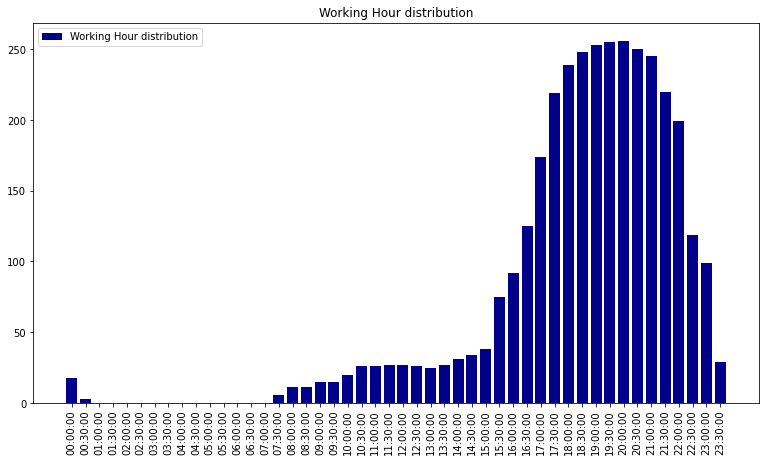

In [6]:
barplot(counts,'Working Hour distribution')

Each value is a working day. Having a value of 100 at 16.00 means that I was working hundred times at that hour.

We observe that the working time is centered around 20.00 with a greater amount of schedule in the late afternoon rather than the morning. Last clock-out is at 00.30

In [7]:
#We consider only the working blocks that have more than 50 counts for statisticul purpose
#we analyze then the time frame period from 15.30 to 23.00
fdelhrs = {x: delhrs[x] for x in delhrs.keys() if x in pd.date_range('15:30','23:00',freq='30min').strftime('%H:%M:%S')}
ftipdel = {x: tipdel[x] for x in tipdel.keys() if x in pd.date_range('15:30','23:00',freq='30min').strftime('%H:%M:%S')}

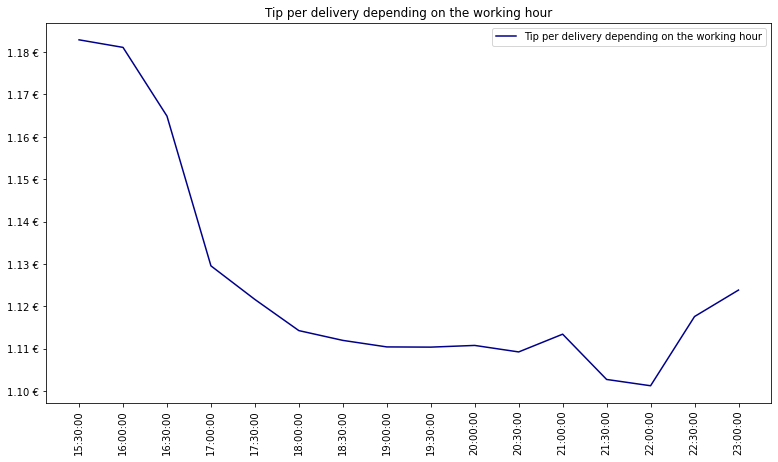

In [8]:
plot(ftipdel,'Tip per delivery depending on the working hour')

* There is a 7 cents difference from 15.30 to 18.00; the drop appears mainly from 16.00 to 17.00 (5 cents drop) .
* From 18.00 to 22.00 the tip per delivery ratio stay costant at 1.11-1.10 € per delivery.
* Last hour (from 22.00 to 23.00)  seems to increase again of 2 cents to a value of 1.12€/cent

In [25]:
def plot(diz,z):
    fig, ax = plt.subplots(figsize=(13,7)) 
    ax.plot(diz.keys(),diz.values(), color='darkred',label=z)
    plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f del/hr'))
    plt.title(z)
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()


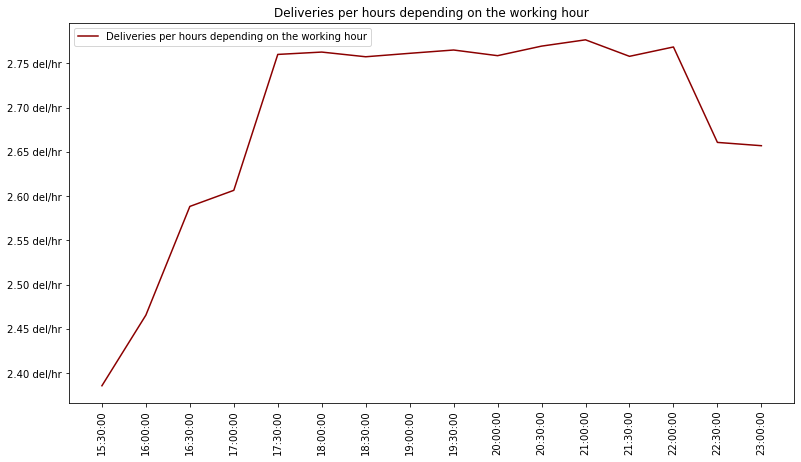

In [26]:
plot(fdelhrs,'Deliveries per hours depending on the working hour')

* The delivery per hour ratio rise constantly from 2.40 to 2,75 in the time period 15.30 - 17.30 .
* It remains constant at 2,75 del/hr from 17.30 to 22.00.
* In the last hour (22.00 - 23.00), drops from 2,75 to 2.65 del/hr.

In [ ]:
def plot(diz,z):
    fig, ax = plt.subplots(figsize=(13,7)) 
    ax.plot(diz.keys(),diz.values(), color='darkblue',label=z)
    plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f del/hr'))
    plt.title(z)
    plt.xticks(rotation=90)
    plt.legend()
    plt.show()


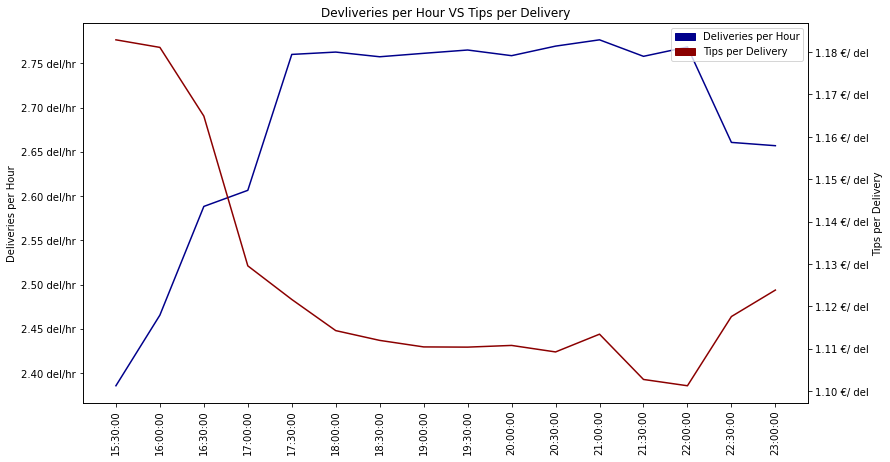

In [76]:
fig, ax = plt.subplots(figsize=(13,7)) 
ax2 = ax.twinx() # Create another axes that shares the same x-axis as ax.
ax.plot(fdelhrs.keys(),fdelhrs.values(), color='darkblue',label='zione')
ax2.plot(ftipdel.keys(),ftipdel.values(), color='darkred',label='Tip per delivery')
ax.set_ylabel('Deliveries per Hour')
ax2.set_ylabel('Tips per Delivery')

#it's not an elegant solution to do a cycle but it works fine
s=0
for ax in fig.axes:
    s+=1
    plt.sca(ax)
    plt.xticks(rotation=90)
    if s==1:
        plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f del/hr'))
    else:
        plt.gca().yaxis.set_major_formatter(mticker.FormatStrFormatter('%.2f €/ del'))

blue_patch = mpatches.Patch(color='darkblue', label='Deliveries per Hour')
red_patch = mpatches.Patch(color='darkred', label='Tips per Delivery')

plt.title('Devliveries per Hour VS Tips per Delivery')
plt.legend(handles=[blue_patch,red_patch])
plt.show()

By merging the two graphs we can observe that those apparently disconnected parameters are negatively correlated instead. 
* It is difficult to find a plausible explanation of this strange pattern, a possible hint could be that by having more orders completed in one hour, increases also the **avarage completion time** per order. That means more time waiting for custumers, a dissatisfaction that reflects on tips per delivery parameter.

# Limitations of the study
As stated before the data are obtained taking advantage of overlapping time of scheduled frame. This could makes sense in huge amount of data that spread randomly in all the time of a working day (from 07.00 to 23.00). 

The reality of those data is that there are two main clock-in point (at 15.30 and 17.00) affecting the freely dispersed time-frame hypothesis at the base of the study. Data are then heavily avaraged thus affected by three three main overlapping period.
